In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3419_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4176_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3370_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1255_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/660_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/484_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4221_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2396_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/543_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3017_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1482_left.jpg
/kaggle/input/ocular-disease-recognit

In [2]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
df.H.value_counts()

0    6189
1     203
Name: H, dtype: int64

In [4]:
df.shape

(6392, 19)

In [5]:
def has_hypertensive(text):
    if ('hypertensive') in text:
        return 1
    else:
        return 0

In [6]:
df["left_hypertensive"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_hypertensive(x))
df["right_hypertensive"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_hypertensive(x))

In [7]:
left_hypertensive = df.loc[(df.H ==1) & (df.left_hypertensive == 1)]["Left-Fundus"].values
left_hypertensive[:15]

array(['11_left.jpg', '23_left.jpg', '28_left.jpg', '32_left.jpg',
       '45_left.jpg', '62_left.jpg', '116_left.jpg', '120_left.jpg',
       '127_left.jpg', '139_left.jpg', '176_left.jpg', '179_left.jpg',
       '272_left.jpg', '296_left.jpg', '300_left.jpg'], dtype=object)

In [8]:
right_hypertensive = df.loc[(df.H ==1) & (df.right_hypertensive == 1)]["Right-Fundus"].values
right_hypertensive[:15]

array(['11_right.jpg', '23_right.jpg', '28_right.jpg', '32_right.jpg',
       '45_right.jpg', '62_right.jpg', '95_right.jpg', '116_right.jpg',
       '120_right.jpg', '127_right.jpg', '139_right.jpg', '176_right.jpg',
       '179_right.jpg', '272_right.jpg', '296_right.jpg'], dtype=object)

In [9]:
print("Number of images in left hypertensive: {}".format(len(left_hypertensive)))
print("Number of images in right hypertensive: {}".format(len(right_hypertensive)))

Number of images in left hypertensive: 191
Number of images in right hypertensive: 191


In [10]:
left_normal = df.loc[(df.H ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(170,random_state=42).values
right_normal = df.loc[(df.H ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(170,random_state=42).values
right_normal[:15]

array(['3240_right.jpg', '2501_right.jpg', '2905_right.jpg',
       '2341_right.jpg', '2430_right.jpg', '2545_right.jpg',
       '3050_right.jpg', '1195_right.jpg', '974_right.jpg',
       '2367_right.jpg', '2646_right.jpg', '408_right.jpg',
       '2576_right.jpg', '2601_right.jpg', '2419_right.jpg'], dtype=object)

In [11]:
hypertensive = np.concatenate((left_hypertensive,right_hypertensive),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [12]:
print(len(hypertensive),len(normal))

382 340


In [13]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [14]:
dataset = create_dataset(hypertensive,1)

100%|██████████| 382/382 [00:03<00:00, 119.60it/s]


In [15]:
dataset = create_dataset(normal,0)

100%|██████████| 340/340 [00:03<00:00, 86.70it/s]


In [16]:
len(dataset)

721

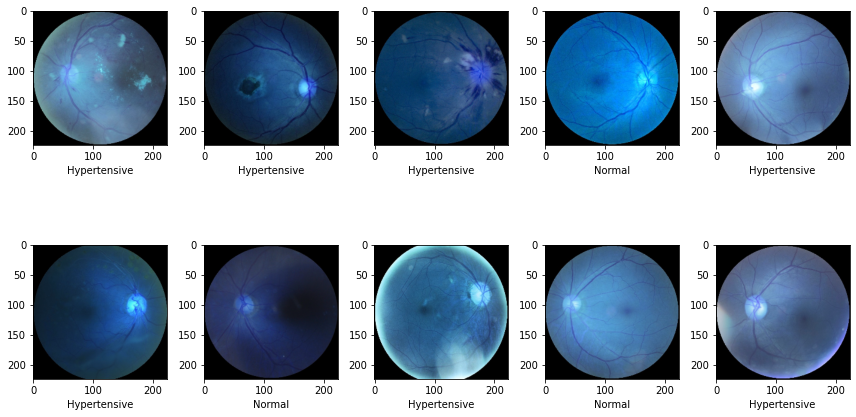

In [17]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Hypertensive"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [18]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [19]:
print(x.shape)
print(y.shape)

(721, 224, 224, 3)
(721,)


In [20]:
# Get the Barchat
gt_t = []
for g in y:
    if g == 0:
        gt_t.append("Normal")
    else:
        gt_t.append("Hypertensive")
        
gt_t = np.array(gt_t)

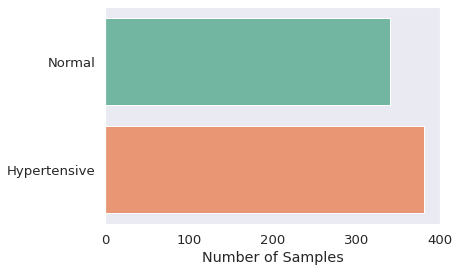

In [21]:
import seaborn as sns
sns.set(style="dark", font_scale=1.2)
ax = sns.countplot(y=gt_t, palette="Set2")

ax.set(xlabel='Number of Samples')
plt.grid(False)
plt.show()

In [39]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [40]:
print(f'x_train',x_train.shape)
print(f'x_test',x_test.shape)
print(f'y_train',y_train.shape)
print(f'y_test',y_test.shape)

x_train (576, 224, 224, 3)
x_test (145, 224, 224, 3)
y_train (576,)
y_test (145,)


In [41]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [42]:
for layer in vgg.layers:
    layer.trainable = False

In [43]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [45]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [47]:
history = model.fit(x_train,y_train,batch_size=32,epochs=20,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/20
18/18 [==============================] - 4s 201ms/step - loss: 4.6920 - accuracy: 0.5955 - val_loss: 3.4839 - val_accuracy: 0.6276
Epoch 2/20
18/18 [==============================] - 2s 91ms/step - loss: 1.7013 - accuracy: 0.7674 - val_loss: 2.7944 - val_accuracy: 0.7034
Epoch 3/20
18/18 [==============================] - 2s 90ms/step - loss: 0.5358 - accuracy: 0.8837 - val_loss: 0.9691 - val_accuracy: 0.8345
Epoch 4/20
18/18 [==============================] - 2s 90ms/step - loss: 0.1715 - accuracy: 0.9479 - val_loss: 1.1037 - val_accuracy: 0.8276
Epoch 5/20
18/18 [==============================] - 2s 92ms/step - loss: 0.0616 - accuracy: 0.9722 - val_loss: 0.7753 - val_accuracy: 0.8690
Epoch 6/20
18/18 [==============================] - 2s 91ms/step - loss: 0.0136 - accuracy: 0.9965 - val_loss: 0.7035 - val_accuracy: 0.8966
Epoch 7/20
18/18 [==============================] - 2s 90ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.6689 - val_accuracy: 0.8828
Epoch 8/20
1

In [48]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

5/5 [==============================] - 0s 69ms/step - loss: 0.6820 - accuracy: 0.8897
loss: 0.6819586157798767
Accuracy: 0.8896551728248596


In [49]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

In [50]:
accuracy_score(y_test,y_pred)

0.8896551724137931

In [51]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        66
           1       0.86      0.95      0.90        79

    accuracy                           0.89       145
   macro avg       0.90      0.88      0.89       145
weighted avg       0.89      0.89      0.89       145



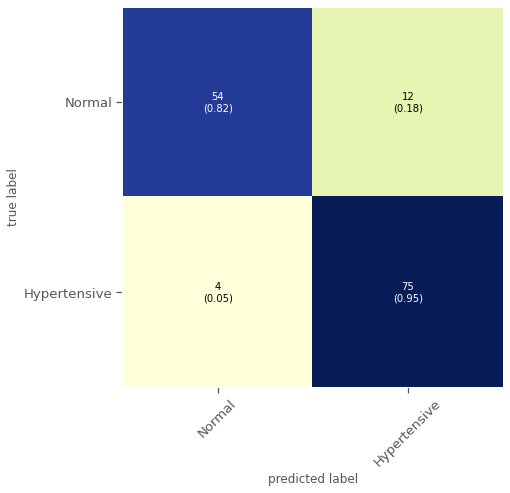

In [52]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Hypertensive"],
                      show_normed = True, cmap ='YlGnBu');

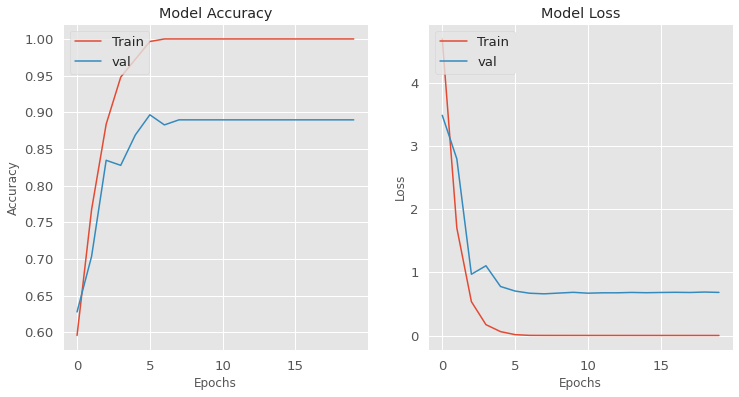

In [53]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Hypertensiven"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Hypertensive"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 